### Import Library

In [3]:
import pandas as pd   # Import pustaka pandas untuk manipulasi data
import matplotlib.pyplot as plt   # Import matplotlib untuk visualisasi dasar
import seaborn as sns     # Import seaborn untuk visualisasi statistik
import re   # Import regex
import string   # Import pustaka string
import nltk   # Import pustaka NLTK (Natural Language Toolkit) untuk pemrosesan bahasa alami
from nltk.tokenize import word_tokenize   # Import fungsi tokenisasi kata dari NLTK
from nltk.corpus import stopwords # Import daftar stopwords dari NLTK
from nltk.stem import WordNetLemmatizer   # Import lemmatizer untuk mengubah kata ke bentuk dasarnya
from sklearn.feature_extraction.text import TfidfVectorizer   # Import TfidfVectorizer dari sklearn
nltk.download('punkt')    # Mengunduh tokenizer kata dari NLTK
nltk.download('punkt_tab')
nltk.download('wordnet')    # Mengunduh data WordNet yang dibutuhkan untuk lemmatization
nltk.download('stopwords')  # Mengunduh daftar stopwords bahasa Inggris
from sklearn.feature_extraction.text import TfidfVectorizer   # Untuk mengubah teks menjadi representasi numerik berbasis TF-IDF (Term Frequency-Inverse Document Frequency)
from sklearn.linear_model import LogisticRegression   # Untuk membuat model klasifikasi berbasis Logistic Regression
from sklearn.metrics import classification_report, confusion_matrix   # Untuk menghitung dan menampilkan metrik evaluasi klasifikasi seperti precision, recall, f1-score, confusion matrix
from sklearn.ensemble import RandomForestClassifier   # Untuk membuat model klasifikasi berbasis Random Forest
import numpy as np    # Untuk manipulasi array dan operasi numerik
import tensorflow as tf   # Library utama untuk deep learning berbasis neural network
from tensorflow.keras.utils import to_categorical   # Untuk mengubah label menjadi one-hot encoding (contoh: label 2 -> [0, 0, 1])
from tensorflow.keras.preprocessing.sequence import pad_sequences   # Untuk memastikan semua input teks (yang sudah di-tokenize) memiliki panjang yang sama dengan padding
from tensorflow.keras.models import Sequential    # Untuk membangun model neural network secara bertahap (layer by layer)
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Attention, Flatten   # Untuk menambahkan berbagai layer ke model
from tensorflow.keras.callbacks import EarlyStopping    # Untuk menghentikan training lebih awal jika model tidak membaik lagi, mencegah overfitting
from tensorflow.keras.preprocessing.text import Tokenizer   # Untuk mengubah teks menjadi urutan angka berdasarkan frekuensi kata (tokenizing)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Data

In [4]:
train_data = pd.read_csv("train.csv")   # Membaca data training dari file CSV
test_data = pd.read_csv("test.csv")   # Membaca data test dari file CSV
train_data.dropna(inplace=True)   # Menghapus baris yang memiliki nilai kosong pada train_data
train_data.info()   # Menampilkan summary struktur data

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [5]:
# Menampilkan 5 baris pertama dari data training
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### Exploratory Data Analysis

In [6]:
# Mengelompokkan data berdasarkan sentimen dan menghitung jumlahnya
temp = train_data.groupby('sentiment').count()['text'].reset_index().sort_values(by='text', ascending=False)

# Menampilkan hasil pengelompokan
temp

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


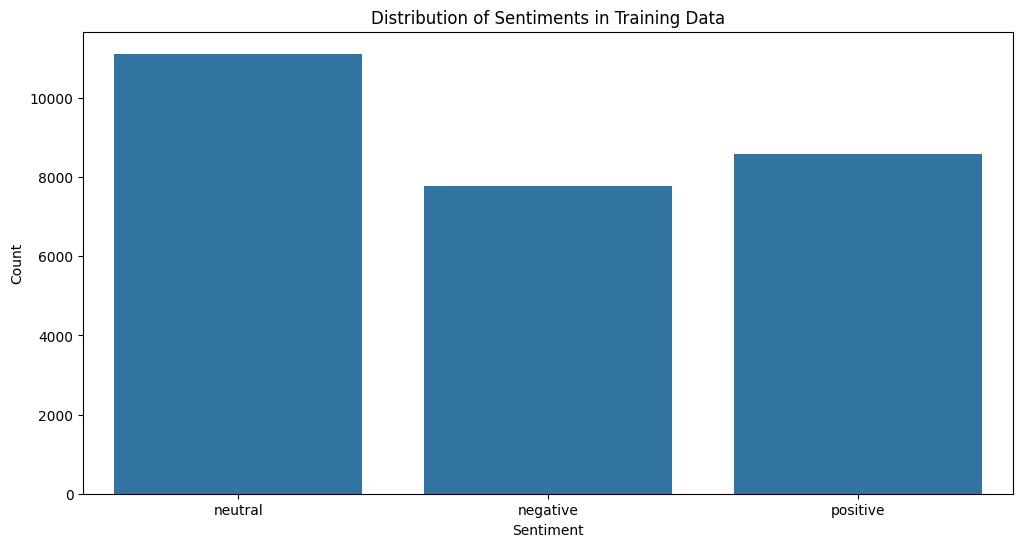

In [7]:
# Membuat plot distribusi sentimen
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment', data=train_data)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in Training Data')
plt.show()

Interpretasi :
- Neutral paling banyak (lebih dari 11.000 data).
- Positive dan Negative jumlahnya hampir mirip, sekitar 7.800–8.600 data.

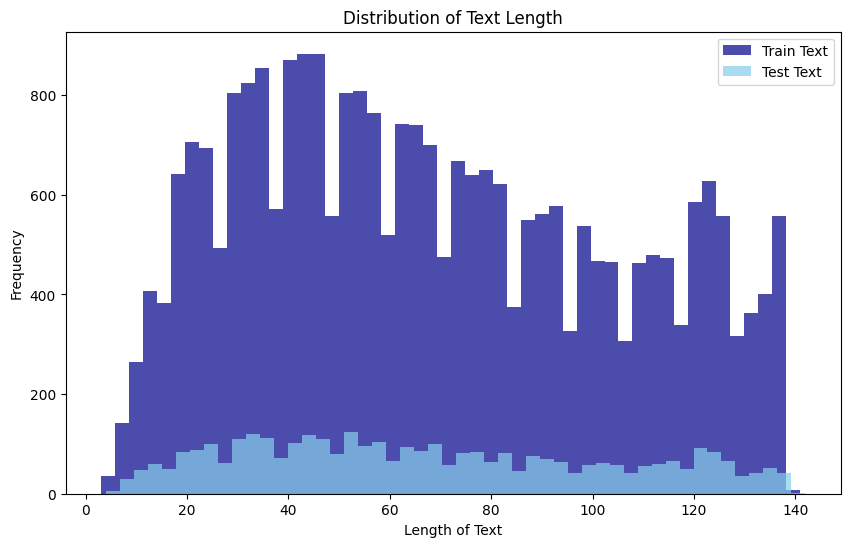

In [8]:
length_train = train_data['text'].str.len()   # Menghitung panjang teks pada data training
length_val = test_data['text'].str.len()    # Menghitung panjang teks pada data test

# Membuat histogram distribusi panjang teks
plt.figure(figsize=(10,6))
plt.hist(length_train, bins=50, label="Train Text", color="darkblue", alpha=0.7)
plt.hist(length_val, bins=50, label='Test Text', color="skyblue", alpha=0.7)
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.legend()
plt.show()

Interpretasinya :
- Sebagian besar teksunya panjang antara 20 sampai 80.
- Puncak frekuensinya sekitar panjang 40–50.
- Ada teks yang sangat pendek (kurang dari 20) dan teks yang sangat panjang (lebih dari 100).

### Data Cleaning

In [9]:
# Menampilkan jumlah nilai kosong pada data test
test_data.isna().sum()

,0
textID,0
text,0
sentiment,0


In [10]:
# Menampilkan jumlah nilai kosong pada data train
train_data.isna().sum()

,0
textID,0
text,0
selected_text,0
sentiment,0


In [11]:
# Menghapus nilai kosong yang tersisa di kedua dataset
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [12]:
# Menampilkan baris pertama dari data pelatihan
print("First Row in the Training Data:")
print(train_data.iloc[0])

print('-' * 30)   # Pemisah

# Menghitung jumlah baris yang sama antara text dan selected_text
matching_rows = len(train_data[train_data['text'] == train_data['selected_text']])
print(f"Number of Matching Rows: {matching_rows}")

First Row in the Training Data:
textID                                     cb774db0d1
text              I`d have responded, if I were going
selected_text     I`d have responded, if I were going
sentiment                                     neutral
Name: 0, dtype: object
------------------------------
Number of Matching Rows: 7283


In [13]:
# Inisialisasi list untuk menyimpan indeks baris kosong di train_data
blanks_train = []

# Iterasi baris di train_data
for i, row in train_data.iterrows():
    tid, t, tst, snt = row    # Unpack kolom
    if isinstance(t, str) and t.isspace():    # Cek jika string kosong
        blanks_train.append(i)

# Jika ada baris kosong, tampilkan jumlah dan hapus
if len(blanks_train) > 0:
    print(f"Number of blank rows in train data: {len(blanks_train)}")
    train_data.drop(blanks_train, inplace=True)

In [14]:
# Inisialisasi list untuk menyimpan indeks baris kosong di test_data
blanks_test = []

# Iterasi baris di test_data
for i, row in test_data.iterrows():
    tid, t, snt = row         # Unpack kolom
    if isinstance(t, str) and t.isspace():    # Cek jika string kosong
        blanks_test.append(i)

# Jika ada baris kosong, tampilkan jumlah dan hapus
if len(blanks_test) > 0:
    print(f"Number of blank rows in test data: {len(blanks_test)}")
    test_data.drop(blanks_test, inplace=True)

### Prep-rocessing Text

In [15]:
# Inisialisasi stopwords
stop_words = set(stopwords.words('english'))

# Fungsi pembersihan teks
def preprocess_text(text):
    # Lowercase
    text = text.lower() #lowering
    # Hapus URL, username, dan karakter non-alphanumeric -> regex
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text)
    # Hapus angka
    text = re.sub(r"\d+", "", text)
    # Hapus karakter spesial
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenisasi
    tokens = word_tokenize(text)
    # Lematisasi
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Hapus stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # Gabungkan kembali tokens menjadi teks
    text = ' '.join(tokens)
    return text   # Kembalikan text

In [16]:
# Terapkan pembersihan teks ke data train
train_data['text'] = train_data['text'].apply(preprocess_text)

# Terapkan pembersihan teks ke data test
test_data['text'] = test_data['text'].apply(preprocess_text)

In [17]:
# Menampilkan 5 baris pertama setelah pembersihan pada data train
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,responded going,"I`d have responded, if I were going",neutral
1,549e992a42,sooo sad miss san diego,Sooo SAD,negative
2,088c60f138,bos bullying,bullying me,negative
3,9642c003ef,interview leave alone,leave me alone,negative
4,358bd9e861,son put release already bought,"Sons of ****,",negative


In [18]:
# Menampilkan 5 baris pertama setelah pembersihan pada data test
test_data.head()

,textID,text,sentiment
0,f87dea47db,last session day,neutral
1,96d74cb729,shanghai also really exciting precisely skyscr...,positive
2,eee518ae67,recession hit veronique branquinho ha quit com...,negative
3,01082688c6,happy bday,positive
4,33987a8ee5,like,positive


### Vektorisasi Teks

In [19]:
# Inisialisasi vektorisasi TF-IDF
vectorizer = TfidfVectorizer(min_df=5,
                             max_df=0.8,
                             sublinear_tf=True,
                             use_idf=True)

# Vektorisasi teks pada data train
train_vectors = vectorizer.fit_transform(train_data['text'])

# Vektorisasi teks pada data test
test_vectors = vectorizer.transform(test_data['text'])

### Split Dataset

In [20]:
# Menyimpan vektor teks sebagai fitur dan target pada data train
X_train = train_vectors
y_train = train_data['sentiment']

# Menyimpan vektor teks sebagai fitur dan target pada data test
X_test = test_vectors
y_test = test_data['sentiment']

### Machine Learning Algorithm

In [21]:
# Training model Logistic Regression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [22]:
# Fungsi evaluation matrix
def show_metrics_eval(y_true, y_pred, grid=None):
    print(classification_report(y_true, y_pred))
    print('-' * 30)
    print(confusion_matrix(y_true, y_pred))

In [23]:
# Evaluasi pada data train model Linear Regression
y_pred_train_lr = model_lr.predict(X_train)
show_metrics_eval(y_train, y_pred_train_lr)

              precision    recall  f1-score   support

    negative       0.81      0.69      0.74      7781
     neutral       0.71      0.83      0.76     11117
    positive       0.83      0.77      0.80      8582

    accuracy                           0.77     27480
   macro avg       0.78      0.76      0.77     27480
weighted avg       0.78      0.77      0.77     27480

------------------------------
[[5345 2084  352]
 [ 966 9180  971]
 [ 271 1713 6598]]


In [24]:
# Evaluasi pada data test model Linear Regression
y_pred_lr = model_lr.predict(X_test)
show_metrics_eval(y_test, y_pred_lr)

              precision    recall  f1-score   support

    negative       0.72      0.64      0.68      1001
     neutral       0.64      0.74      0.69      1430
    positive       0.80      0.70      0.75      1103

    accuracy                           0.70      3534
   macro avg       0.72      0.70      0.70      3534
weighted avg       0.71      0.70      0.70      3534

------------------------------
[[ 640  324   37]
 [ 211 1061  158]
 [  44  282  777]]


In [25]:
# Training model Random Forest
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
# Evaluasi pada data train model Random Forest
y_pred_train_rf = model_rf.predict(X_train)
show_metrics_eval(y_train, y_pred_train_rf)

              precision    recall  f1-score   support

    negative       1.00      0.98      0.99      7781
     neutral       0.98      0.99      0.99     11117
    positive       0.99      0.99      0.99      8582

    accuracy                           0.99     27480
   macro avg       0.99      0.99      0.99     27480
weighted avg       0.99      0.99      0.99     27480

------------------------------
[[ 7661   107    13]
 [   26 11050    41]
 [    6    80  8496]]


In [27]:
# Evaluasi pada data test model Random Forest
y_pred_rf = model_rf.predict(X_test)
show_metrics_eval(y_test, y_pred_rf)

              precision    recall  f1-score   support

    negative       0.72      0.64      0.68      1001
     neutral       0.67      0.72      0.69      1430
    positive       0.76      0.76      0.76      1103

    accuracy                           0.71      3534
   macro avg       0.72      0.71      0.71      3534
weighted avg       0.71      0.71      0.71      3534

------------------------------
[[ 645  286   70]
 [ 206 1025  199]
 [  44  218  841]]


In [28]:
# Fungsi untuk melakukan inferensi/prediksi sentimen dari teks menggunakan model dan vectorizer yang diberikan
def infference_sentiment_vectorizer(text, model, vectorizer):
    # Mengubah teks input menjadi vektor fitur menggunakan vectorizer (TF-IDF)
    text_vector = vectorizer.transform([text])
    sentiment = model.predict(text_vector)    # Menggunakan model untuk memprediksi sentimen dari vektor teks
    return sentiment  # Mengembalikan hasil prediksi

In [29]:
text = "I am feeling great today!"      # Contoh teks yang ingin diprediksi sentimennya
sentiment_lr = infference_sentiment_vectorizer(text, model_lr, vectorizer)  # Melakukan inferensi sentimen menggunakan model Logistic Regression
sentiment_rf = infference_sentiment_vectorizer(text, model_rf, vectorizer)  # Melakukan inferensi sentimen menggunakan model Random Forest

# Menampilkan hasil prediksi sentimen dari masing-masing model
print(f"Sentimen Linear Regression: {sentiment_lr[0]}")
print(f"Sentimen Random Forest: {sentiment_rf[0]}")

Sentimen Linear Regression: positive
Sentimen Random Forest: positive


Interpretasi:
- Model Linear Regression cukup baik, dengan hasil f1 score 76%
- Model Random Forest mengalami overfitting karna hasil evaluasai pada data train sangat baik, namun pada data test berbeda jauh (lebih rendah)
- kita akan coba menggunakan model Deep Learning

### Deep Learning Algorithm

In [30]:
max_len = 32    # Menentukan panjang maksimal input teks
num_words = 500   # Menentukan jumlah kata yang akan dipertahankan

tokenizer = Tokenizer(num_words=num_words)  # Membuat tokenizer untuk memetakan kata menjadi indeks
tokenizer.fit_on_texts(train_data['text'])  # Melatih tokenizer pada teks training

In [31]:
# Menampilkan 5 data train
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,responded going,"I`d have responded, if I were going",neutral
1,549e992a42,sooo sad miss san diego,Sooo SAD,negative
2,088c60f138,bos bullying,bullying me,negative
3,9642c003ef,interview leave alone,leave me alone,negative
4,358bd9e861,son put release already bought,"Sons of ****,",negative


In [32]:
# Menyiapkan data teks dan label untuk training (fitur & target)
X_train = train_data['text']
y_train = train_data['sentiment']

# Menyiapkan data teks dan label untuk testing  (fitur & target)
X_test = test_data['text']
y_test = test_data['sentiment']

In [33]:
# Menampilkan data fitur train
X_train

,text
0,responded going
1,sooo sad miss san diego
2,bos bullying
3,interview leave alone
4,son put release already bought
...,...
27476,wish could come see u denver husband lost job ...
27477,wondered rake client ha made clear net force d...
27478,yay good enjoy break probably need hectic week...
27479,wa worth


In [34]:
# Mengubah teks menjadi urutan angka (sequence of word indices)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [35]:
# Menampilkan data fitur train yang sudah disequence (diurutkan)
X_train_seq

[[12],
 [301, 53, 36],
 [],
 [246, 375],
 [217, 121, 453],
 [83],
 [172, 47],
 [454, 455],
 [],
 [150, 8, 405],
 [34, 9, 196, 95, 59, 30, 4, 485, 208],
 [19, 19, 5, 126, 9],
 [412],
 [21, 6, 215, 52, 213],
 [456, 456],
 [32],
 [92, 131, 457],
 [113, 1, 221, 56, 294, 49, 56],
 [18, 27, 59, 30, 36, 284, 14],
 [],
 [32, 51, 37, 128, 91],
 [276, 366, 19, 26, 382, 158, 81],
 [123, 223, 186, 11],
 [7, 188, 369, 127, 353, 2, 486, 217, 236],
 [22, 153, 499, 383, 122],
 [281, 47, 20],
 [51],
 [65, 354],
 [335, 159, 47, 288],
 [140, 66, 18, 96],
 [12, 27, 299, 26, 46, 373],
 [37, 39],
 [7, 302, 61, 28, 34, 288],
 [261, 266, 193],
 [197, 59, 30, 174, 83, 129, 48, 63, 37, 184],
 [222, 236],
 [86, 31, 36],
 [19, 349, 11, 203, 26, 398, 382, 330],
 [41, 1, 76, 2, 11],
 [93, 16, 92, 281, 13, 487, 9, 1],
 [170, 16, 151, 151, 443, 12, 218],
 [20, 285, 9],
 [],
 [14, 50, 5, 31, 47, 78, 29, 54, 247, 56],
 [9, 384, 49, 9, 191],
 [87, 221, 130, 40],
 [116, 30, 6, 10, 20],
 [391],
 [5, 156, 79, 5, 12, 351, 4

In [36]:
# Menyamakan panjang semua sequence dengan padding
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

In [37]:
X_train_padded

array([[  0,   0,   0, ...,   0,   0,  12],
       [  0,   0,   0, ..., 301,  53,  36],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  68,  88, 487],
       [  0,   0,   0, ...,   0,   0,   2],
       [  0,   0,   0, ...,  12, 139, 329]], dtype=int32)

In [38]:
# Mengubah label menjadi one-hot encoding
y_train = pd.get_dummies(y_train, drop_first=True, dtype=int).to_numpy()
y_test = pd.get_dummies(y_test, drop_first=True, dtype=int).to_numpy()

In [39]:
# Menampilkan target train yang sudah di one-hot encoding
y_train

array([[1, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]])

In [40]:
# Fungsi untuk membangun arsitektur model LSTM
def function_lstm(units, dropout_rate):
    model = Sequential()    # Membuat model sequential (berlapis-lapis)
    model.add(Embedding(num_words, 32, input_length=max_len))   # Menambahkan layer embedding untuk mengubah token menjadi vektor 32 dimensi
    model.add(LSTM(units))    # Menambahkan layer LSTM dengan jumlah unit yang ditentukan
    model.add(Dropout(dropout_rate))    # Menambahkan layer dropout untuk mencegah overfitting
    model.add(Dense(2, activation='sigmoid'))   # Menambahkan output layer dan aktivasi sigmoid
    return model    # Mengembalikan model yang telah dibangun

# Fungsi untuk membangun arsitektur model GRU
def function_gru(units, dropout_rate):
    model = Sequential()    # Membuat model sequential (berlapis-lapis)
    model.add(Embedding(num_words, 32, input_length=max_len))   # Menambahkan layer embedding untuk mengubah token menjadi vektor 32 dimensi
    model.add(GRU(units))   # Menambahkan layer GRU dengan jumlah unit yang ditentukan
    model.add(Dropout(dropout_rate))    # Menambahkan layer dropout untuk mencegah overfitting
    model.add(Dense(2, activation='sigmoid'))   # Menambahkan output layer dan aktivasi sigmoid
    return model   # Mengembalikan model yang telah dibangun

# Fungsi untuk membangun arsitektur model RNN
def function_rnn(units, dropout_rate):
    model = Sequential()    # Membuat model sequential (berlapis-lapis)
    model.add(Embedding(num_words, 128, input_length=max_len))    # Menambahkan layer embedding untuk mengubah token menjadi vektor 128 dimensi
    model.add(SimpleRNN(units))   # Menambahkan layer Simple RNN dengan jumlah unit yang ditentukan
    model.add(Dropout(dropout_rate))    # Menambahkan layer dropout untuk mencegah overfitting
    model.add(Dense(2, activation='sigmoid'))   # Menambahkan output layer dan aktivasi sigmoid
    return model   # Mengembalikan model yang telah dibangun

In [41]:
# Menentukan jumlah unit pada RNN/LSTM/GRU dan dropout rate
units = 128
dropout_rate = 0.3

In [42]:
# Membuat dan compile model RNN
rnn_model = function_rnn(units, dropout_rate)
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Membuat dan compile model LSTM
lstm_model = function_lstm(units, dropout_rate)
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Membuat dan compile model GRU
gru_model = function_gru(units, dropout_rate)
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
# Membuat early stopping untuk menghentikan training jika model tidak membaik
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

In [44]:
# Melatih model RNN
rnn_history = rnn_model.fit(X_train_padded, y_train, epochs=20, batch_size=128,
                            validation_split=0.2, callbacks=[early_stopping])

# Melatih model LSTM
lstm_history = lstm_model.fit(X_train_padded, y_train, epochs=20, batch_size=128,
                              validation_split=0.2, callbacks=[early_stopping])

# Melatih model GRU
gru_history = gru_model.fit(X_train_padded, y_train, epochs=20, batch_size=128,
                            validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5446 - loss: 0.5643 - val_accuracy: 0.7012 - val_loss: 0.4867
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5392 - loss: 0.5945 - val_accuracy: 0.7012 - val_loss: 0.4839
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5334 - loss: 0.5966 - val_accuracy: 0.7012 - val_loss: 0.4844
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5338 - loss: 0.5938 - val_accuracy: 0.7012 - val_loss: 0.4840
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6660 - loss: 0.5893 - val_accuracy: 0.7012 - val_loss: 0.4842
Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5769 - loss: 0.5501 - val_accuracy: 0.7012 - val_loss: 0.4819
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5342 - loss: 0.6016 - val_accuracy: 0.7012 - val_loss: 0.4840
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5339 - loss: 0.5977 - val_accuracy: 

In [45]:
# Mengambil nilai akurasi validasi terbaik dari masing-masing model
rnn_val_acc = max(rnn_history.history['val_accuracy'])
lstm_val_acc = max(lstm_history.history['val_accuracy'])
gru_val_acc = max(gru_history.history['val_accuracy'])
max_val_acc = max(rnn_val_acc, lstm_val_acc, gru_val_acc)   # Akurasi validasi terbaik di antara ketiga model

# Menampilkan akurasi validasi dari masing-masing model
print("RNN Validation Accuracy:", rnn_val_acc)
print("LSTM Validation Accuracy:", lstm_val_acc)
print("GRU Validation Accuracy:", gru_val_acc)
print('-' * 50)
print("Max Validation Accuracy:", max_val_acc)

RNN Validation Accuracy: 0.7012372612953186
LSTM Validation Accuracy: 0.7012372612953186
GRU Validation Accuracy: 0.8193231225013733
--------------------------------------------------
Max Validation Accuracy: 0.8193231225013733


In [46]:
# Fungsi untuk melakukan inferensi sentimen dari sebuah teks
def infer_sentiment(text, model, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences([text])    # Mengubah teks jadi sequence angka
    padded_sequences = pad_sequences(sequences, maxlen=max_length)  # Padding agar panjang sesuai
    prediction = model.predict(padded_sequences)  # Melakukan prediksi

    predicted_class = np.argmax(prediction) # Mengambil kelas dengan probabilitas tertinggi
    if predicted_class == 0:
        sentiment = "Negatif"
        print(sentiment)
    elif predicted_class == 1:
        sentiment = "Netral"
        print(sentiment)
    else:
        sentiment = "Positif"
        print(sentiment)

    return sentiment

In [47]:
# Contoh teks untuk inferensi
text = "I really hate rainy days. Everything is so bad and depressing."
max_length = X_train_padded.shape[1]  # Mengambil panjang maksimal input

# Inferensi sentimen menggunakan ketiga model
rnn_sentiment = infer_sentiment(text, rnn_model, tokenizer, max_length)
lstm_sentiment = infer_sentiment(text, lstm_model, tokenizer, max_length)
gru_sentiment = infer_sentiment(text, gru_model, tokenizer, max_length)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Negatif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Negatif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Negatif


Interpretasi akhir :
- Model machine learning terbaik adalah random forest dengan f1 score 76%
- Model deep learning terbaik adalah GRU dengan validation accuracy 82%